# GRU — Prédiction autorégressiive de la dernière semaine

## Objectif
Ce notebook construit un **GRU (Gated Recurrent Unit)** pour prédire `Total_reservations`
en utilisant une **fenêtre glissante de 5 jours (1 semaine)**.

### Stratégie de prédiction autorégressiive
Pour prédire la **dernière semaine** du dataset (semaine 39 / 2023) :
1. Le GRU est alimenté avec les 5 jours précédents → il prédit le **Lundi**
2. La fenêtre **glisse** : ce Lundi prédit intègre la fenêtre
3. On prédit le **Mardi**, puis la fenêtre glisse à nouveau
4. On répète jusqu'au **Vendredi** (5 prédictions chaînées)

```
Fenêtre initiale           Prédiction     Nouvelle fenêtre
[L38 M38 Me38 J38 V38]  →  ŷ_L39   →  [M38 Me38 J38 V38 ŷ_L39]
[M38 Me38 J38 V38 ŷ_L39] → ŷ_M39   →  [Me38 J38 V38 ŷ_L39 ŷ_M39]
...
```

## Pourquoi le GRU est efficace ?

Le GRU simplifie le LSTM en fusionnant les portes oublier/entrée en une **porte de mise à jour** $z_t$
et en introduisant une **porte de réinitialisation** $r_t$ :
$$h_t = (1 - z_t) \\odot h_{t-1} + z_t \\odot \\tilde{h}_t$$

Résultat : **moins de paramètres**, entraînement plus rapide, performances comparables au LSTM
sur des séries courtes.

## 1 — Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : cpu


## 2 — Chargement et tri chronologique

In [10]:
DATA_PATH = '../data/df_venues_final.csv'

df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
print(f"Période : {df['Annee'].min()}/S{df['Semaine'].min()} → {df['Annee'].max()}/S{df['Semaine'].max()}")
print('\n--- Dernière semaine (cible de prédiction) ---')
print(df[['Annee', 'Semaine', 'day_num', 'Total_reservations']].tail(5).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine (cible de prédiction) ---
     Annee  Semaine  day_num  Total_reservations
245   2023       39        0                 253
246   2023       39        1                 271
247   2023       39        2                 264
248   2023       39        3                 271
249   2023       39        4                 161


## 3 — Prétraitement et séquences

`Total_reservations` est placé en **indice 0** des features pour faciliter
son remplacement par la prédiction lors de la boucle autorégressiive.

Un seul `MinMaxScaler` est utilisé pour tout normaliser dans $[0,1]$,
garantissant que les valeurs prédites restent dans la même échelle que les entrées.

**Split** : 245 jours entraînement / 5 jours test (dernière semaine).

In [11]:
WINDOW = 5   # une semaine
N_TEST = 5   # dernière semaine réservée au test

FEATURES = [
    'Total_reservations',    # indice 0 — feedback autorégressif
    'GLOBAL', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0   # Total_reservations = feature[0] = cible

scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(df[FEATURES].astype(float))

X_train_raw = X_scaled[:-N_TEST]
X_test_raw  = X_scaled[-N_TEST:]

def make_sequences(X, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])
        ys.append(X[i, TARGET_IDX])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32).reshape(-1, 1)

X_seq, y_seq = make_sequences(X_train_raw, WINDOW)

print(f'Séquences d\'entraînement : {X_seq.shape}  →  {y_seq.shape}')
seed_start = len(df) - N_TEST - WINDOW
print(f'\nFenêtre seed pour la prédiction (indices {seed_start}–{seed_start + WINDOW - 1}) :')
print(df[['Annee', 'Semaine', 'day_num', 'Total_reservations']].iloc[seed_start:seed_start + WINDOW].to_string())

X_tr = torch.tensor(X_seq).to(DEVICE)
y_tr = torch.tensor(y_seq).to(DEVICE)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=16, shuffle=True)


Séquences d'entraînement : (240, 5, 15)  →  (240, 1)

Fenêtre seed pour la prédiction (indices 240–244) :
     Annee  Semaine  day_num  Total_reservations
240   2023       38        0                 254
241   2023       38        1                 312
242   2023       38        2                 275
243   2023       38        3                 279
244   2023       38        4                 167


## 4 — Architecture GRU

```
Input  : (batch, T=5, F=15)
   ↓
GRU(hidden=64, layers=2, dropout=0.2)
   ↓  h_T  (batch, 64)
Dropout(0.2)
   ↓
Linear(64 → 1)
   ↓
Output : Total_reservations normalisé [0, 1]
```

**Différence clé GRU vs LSTM :**
- Le GRU n'a **pas de cellule de contexte** $c_t$, seulement un état caché $h_t$
- La sortie de `nn.GRU` est `(output, h_n)` au lieu de `(output, (h_n, c_n))`
- Le GRU possède **~25 % de paramètres en moins** que le LSTM équivalent

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _  = self.gru(x)               # (batch, T, hidden)  — pas de c_n
        last_h  = out[:, -1, :]             # dernier pas : (batch, hidden)
        return self.fc(self.dropout(last_h)) # (batch, 1)


model = GRUModel(input_size=len(FEATURES), hidden_size=64, num_layers=2).to(DEVICE)
print(model)
print(f'\nNombre de paramètres : {sum(p.numel() for p in model.parameters()):,}')

GRUModel(
  (gru): GRU(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre de paramètres : 40,577


## 5 — Entraînement

In [13]:
EPOCHS    = 200
LR        = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=15, factor=0.5
)

loss_history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(X_seq)
    loss_history.append(epoch_loss)
    scheduler.step(epoch_loss)

    if epoch % 25 == 0:
        lr_cur = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}/{EPOCHS} | Loss : {epoch_loss:.5f} | LR : {lr_cur:.6f}')

print('\nEntraînement terminé.')

Epoch  25/200 | Loss : 0.01930 | LR : 0.001000
Epoch  50/200 | Loss : 0.01693 | LR : 0.000500
Epoch  75/200 | Loss : 0.01502 | LR : 0.000500
Epoch 100/200 | Loss : 0.01491 | LR : 0.000125
Epoch 125/200 | Loss : 0.01417 | LR : 0.000063
Epoch 150/200 | Loss : 0.01557 | LR : 0.000031
Epoch 175/200 | Loss : 0.01353 | LR : 0.000008
Epoch 200/200 | Loss : 0.01403 | LR : 0.000004

Entraînement terminé.


## 6 — Prédiction autorégressiive (fenêtre glissante)

**Étapes détaillées pour chaque jour $t$ de la semaine cible :**

1. Construire le tenseur `x` à partir de la fenêtre courante (5 × 15)
2. Passer `x` dans le GRU → obtenir `ŷ_t` (valeur normalisée)
3. Créer le vecteur du jour $t$ : features exogènes réelles + `Total_reservations = ŷ_t`
4. Glisser la fenêtre : `window = [window[1:], nouveau_jour]`
5. Répéter pour $t+1$

In [14]:
model.eval()

# day_names s'adapte à N_TEST (cycle lundi→vendredi)
_day_cycle = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
day_names  = [_day_cycle[i % 5] for i in range(N_TEST)]

# Label dynamique pour les titres (ex: "S39/2023" ou "S39/2023–S40/2023")
_test_rows = df.iloc[-N_TEST:]
_s_start   = f"S{int(_test_rows.iloc[0]['Semaine'])}/{int(_test_rows.iloc[0]['Annee'])}"
_s_end     = f"S{int(_test_rows.iloc[-1]['Semaine'])}/{int(_test_rows.iloc[-1]['Annee'])}"
test_label = _s_start if _s_start == _s_end else f'{_s_start}–{_s_end}'

# Fenêtre de départ : WINDOW jours avant les N_TEST jours de test
seed_window = X_scaled[-N_TEST - WINDOW : -N_TEST].copy()
preds_norm  = []
window      = seed_window.copy()

print('=== Prédiction autorégressiive (fenêtre glissante) ===')
print(f"{'Étape':<6} {'Jour':<10} {'ŷ norm':>8}   Fenêtre Total_res [normalisé]")
print('-' * 72)

for step in range(N_TEST):
    # Prédiction
    x      = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_n = model(x).item()
    preds_norm.append(pred_n)

    print(f'  {step}     {day_names[step]:<10} {pred_n:>8.4f}   '
          f'{np.round(window[:, TARGET_IDX], 3)}')

    # Nouveau jour : features exogènes réelles + Total_reservations prédit
    new_day               = X_test_raw[step].copy()
    new_day[TARGET_IDX]   = pred_n

    # Glissement
    window = np.vstack([window[1:], new_day.reshape(1, -1)])

# Inverse transform
dummy                = np.zeros((N_TEST, len(FEATURES)))
dummy[:, TARGET_IDX] = preds_norm
preds_real           = scaler.inverse_transform(dummy)[:, TARGET_IDX]
real_real            = df['Total_reservations'].values[-N_TEST:]

print('\n=== Résultats ===')
print(f"{'Jour':<10} | {'Réel':>6} | {'GRU':>6} | {'Erreur':>7} | {'Erreur %':>8}")
print('-' * 46)
for i, d in enumerate(day_names):
    err    = preds_real[i] - real_real[i]
    err_pc = 100 * abs(err) / real_real[i]
    print(f'{d:<10} | {real_real[i]:>6.0f} | {preds_real[i]:>6.0f} | {err:>+7.0f} | {err_pc:>7.1f}%')


=== Prédiction autorégressiive (fenêtre glissante) ===
Étape  Jour         ŷ norm   Fenêtre Total_res [normalisé]
------------------------------------------------------------------------
  0     Lundi        0.6721   [0.671 0.83  0.729 0.74  0.433]
  1     Mardi        0.7886   [0.83  0.729 0.74  0.433 0.672]
  2     Mercredi     0.7317   [0.729 0.74  0.433 0.672 0.789]
  3     Jeudi        0.6548   [0.74  0.433 0.672 0.789 0.732]
  4     Vendredi     0.3408   [0.433 0.672 0.789 0.732 0.655]

=== Résultats ===
Jour       |   Réel |    GRU |  Erreur | Erreur %
----------------------------------------------
Lundi      |    253 |    254 |      +1 |     0.5%
Mardi      |    271 |    297 |     +26 |     9.5%
Mercredi   |    264 |    276 |     +12 |     4.6%
Jeudi      |    271 |    248 |     -23 |     8.5%
Vendredi   |    161 |    133 |     -28 |    17.1%


## 7 — Visualisations

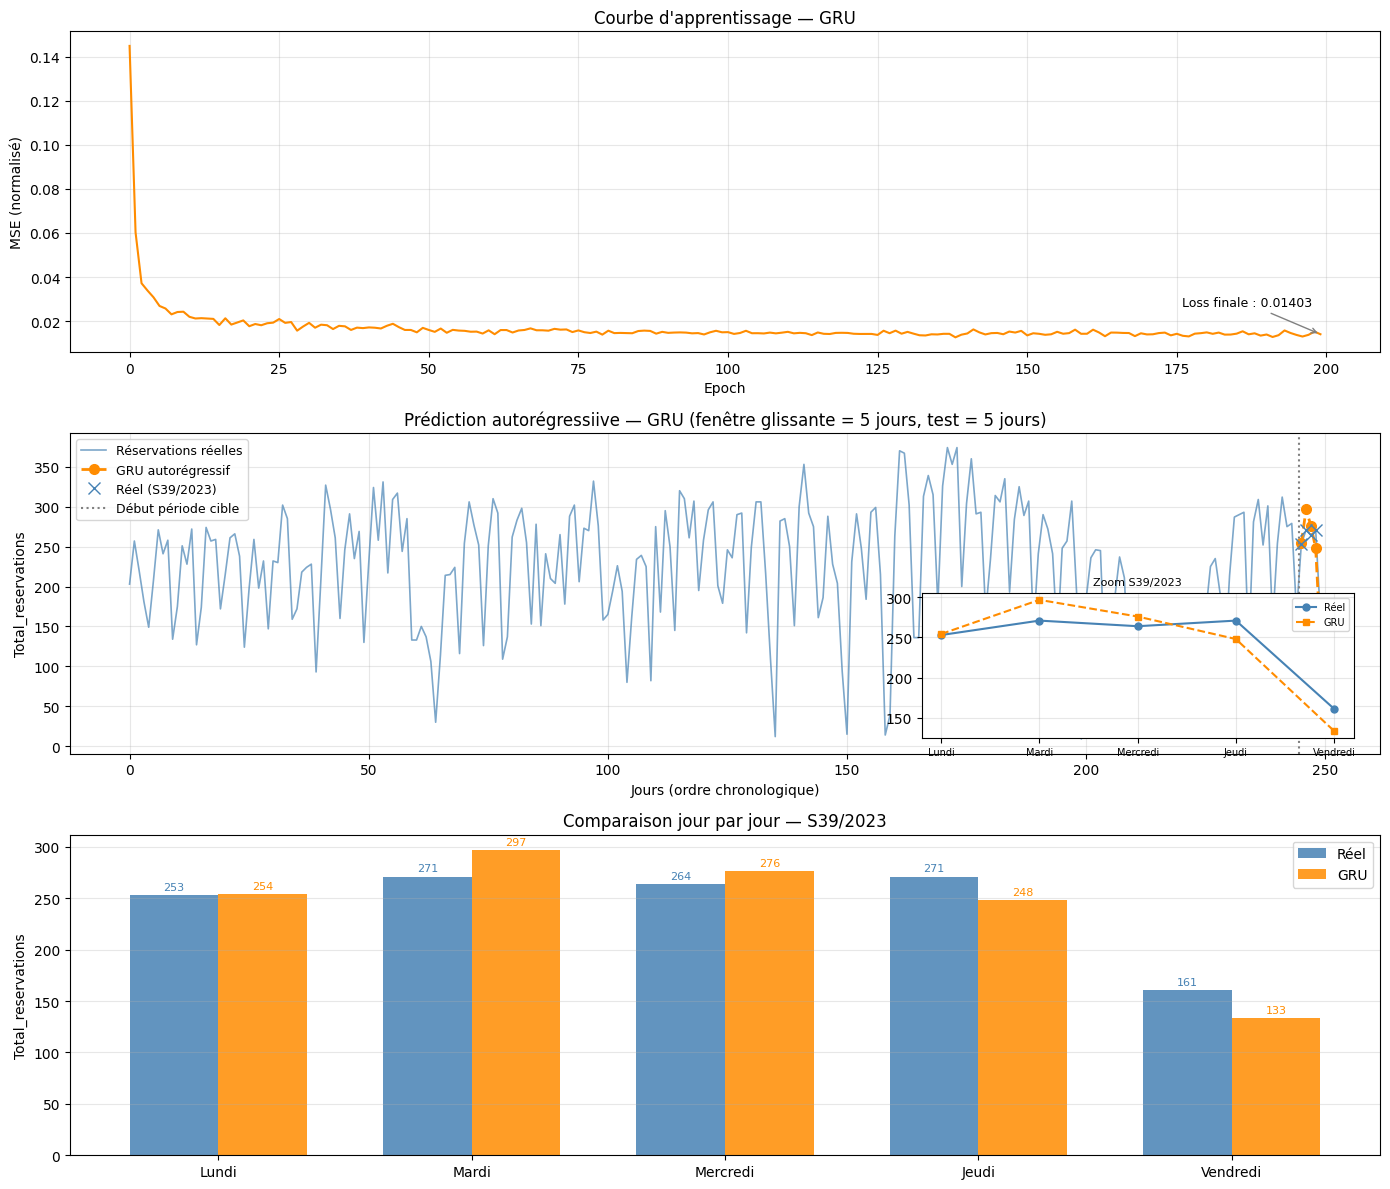

Sauvegardé dans img/gru_predictions.png


In [15]:
all_real     = df['Total_reservations'].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# ── 1 : Courbe d'apprentissage ────────────────────────────────────────────
ax = axes[0]
ax.plot(loss_history, color='darkorange', linewidth=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE (normalisé)')
ax.set_title('Courbe d\'apprentissage — GRU')
ax.grid(alpha=0.3)
ax.annotate(f'Loss finale : {loss_history[-1]:.5f}',
            xy=(len(loss_history) - 1, loss_history[-1]),
            xytext=(-100, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)

# ── 2 : Série complète + prédiction ─────────────────────────────────────
ax = axes[1]
ax.plot(range(len(all_real)), all_real,
        label='Réservations réelles', color='steelblue', alpha=0.7, linewidth=1.2)
ax.plot(test_indices, preds_real,
        label='GRU autorégressif', color='darkorange',
        linestyle='--', marker='o', markersize=7, linewidth=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', markersize=9,
        linestyle='None', label=f'Réel ({test_label})')
ax.axvline(x=test_indices[0] - 0.5, color='gray', linestyle=':',
           linewidth=1.5, label='Début période cible')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel('Total_reservations')
ax.set_title(f'Prédiction autorégressiive — GRU (fenêtre glissante = {WINDOW} jours, test = {N_TEST} jours)')
ax.legend(loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

# Zoom inset
axins = ax.inset_axes([0.65, 0.05, 0.33, 0.45])
axins.plot(day_names, real_real, 'o-', color='steelblue', label='Réel', markersize=5)
axins.plot(day_names, preds_real, 's--', color='darkorange', label='GRU', markersize=5)
axins.set_title(f'Zoom {test_label}', fontsize=8)
axins.tick_params(axis='x', labelsize=7)
axins.legend(fontsize=7)
axins.grid(alpha=0.3)

# ── 3 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[2]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel', color='steelblue', alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label='GRU',  color='darkorange', alpha=0.85)

for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='darkorange')

ax.set_xticks(x)
ax.set_xticklabels(day_names)
ax.set_ylabel('Total_reservations')
ax.set_title(f'Comparaison jour par jour — {test_label}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../img/gru_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé dans img/gru_predictions.png')


## 8 — Métriques

In [16]:
mae  = mean_absolute_error(real_real, preds_real)
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
mape = np.mean(np.abs((real_real - preds_real) / real_real)) * 100
r2   = r2_score(real_real, preds_real)

_title = f'Métriques GRU — {test_label}'
_w     = max(44, len(_title) + 4)
print('╔' + '═' * _w + '╗')
print(f'║  {_title:<{_w - 2}}║')
print('╠' + '═' * _w + '╣')
print(f'║  MAE   (Erreur absolue moyenne)  : {mae:>7.1f}  {"":>{_w - 42}}║')
print(f'║  RMSE  (Racine erreur quadrat.)  : {rmse:>7.1f}  {"":>{_w - 42}}║')
print(f'║  MAPE  (Erreur % moyenne)        : {mape:>6.2f}%  {"":>{_w - 42}}║')
print(f'║  R²    (Coefficient det.)        : {r2:>7.4f}  {"":>{_w - 42}}║')
print('╚' + '═' * _w + '╝')

print('\n=== Trace de la fenêtre glissante ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7}   Rôle")
print('-' * 65)
for i, d in enumerate(day_names):
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f}   {role}')


╔════════════════════════════════════════════╗
║  Métriques GRU — S39/2023                  ║
╠════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    18.0    ║
║  RMSE  (Racine erreur quadrat.)  :    20.5    ║
║  MAPE  (Erreur % moyenne)        :   8.05%    ║
║  R²    (Coefficient det.)        :  0.7614    ║
╚════════════════════════════════════════════╝

=== Trace de la fenêtre glissante ===
Étape   Jour           Réel  Prédit   Rôle
-----------------------------------------------------------------
  0      Lundi           253     254   ← injecté dans la fenêtre suivante
  1      Mardi           271     297   ← injecté dans la fenêtre suivante
  2      Mercredi        264     276   ← injecté dans la fenêtre suivante
  3      Jeudi           271     248   ← injecté dans la fenêtre suivante
  4      Vendredi        161     133   ← prédiction finale
